Project 3 Sentiment Analysis of Reviews
Jean Halaby
11/26/25

In this project I will use the Yelp Fusion API to collect reviews of gyms.

In [2]:
pip install requests textblob nltk wordcloud matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeanhalaby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeanhalaby/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/jeanhalaby/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import re

In [6]:
YELP_API_KEY = "9F_s1ES7zWFSsWT8SlhxAhOVK-Tk_5jGtGgyiJhnct4cDXrGdjAMkMdmmeYTqRdVTEJXbWTPCdAh1fas6JAkQrYLhZ9rWbsVXlhIePicia5XV1UOcb3BryAjn986ZHYx"


HEADERS = {
    "Authorization": f"Bearer {YELP_API_KEY}"
}

In [7]:
def search_businesses(term="gym", location="New York, NY", limit=20):
    """
    Search Yelp for businesses. We use it to find gyms.
    """
    url = "https://api.yelp.com/v3/businesses/search"
    params = {
        "term": term,
        "location": location,
        "limit": limit
    }
    response = requests.get(url, headers=HEADERS, params=params)
    response.raise_for_status()
    data = response.json()
    return data.get("businesses", [])


def get_reviews_for_business(business_id):
    """
    Get up to 3 reviews for a single business.
    """
    url = f"https://api.yelp.com/v3/businesses/{business_id}/reviews"
    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    data = response.json()
    return data.get("reviews", [])

In [11]:
businesses = search_businesses(term="gym", location="New York, NY", limit=25)

len(businesses)

25

In [13]:
all_reviews = []

for b in businesses:
    b_id = b["id"]
    b_name = b["name"]
    reviews = get_reviews_for_business(b_id)
    for r in reviews:
        all_reviews.append({
            "business_id": b_id,
            "business_name": b_name,
            "review_text": r.get("text", ""),
            "rating": r.get("rating", None),
            "time_created": r.get("time_created", None)
        })

73

In [14]:
len(all_reviews)

73

In [15]:
reviews_df = pd.DataFrame(all_reviews)
reviews_df.head()

,business_id,business_name,review_text,rating,time_created
0,DzlmPGxCg3wRyGJiNoSFow,GYM NYC,Loved this place! I lived in NYC for a little ...,5,2024-09-06 06:14:33
1,DzlmPGxCg3wRyGJiNoSFow,GYM NYC,Great small gym in the heart of SOHO. Friendly...,5,2022-05-15 07:08:28
2,DzlmPGxCg3wRyGJiNoSFow,GYM NYC,Great day trip $25 for the day \nGive you towe...,5,2019-11-13 02:15:29
3,Mlo8UphMkoy9XMWHVgZsgA,Mercedes Club,The best gym I've ever been a part of. It's mo...,5,2025-08-21 12:58:17
4,Mlo8UphMkoy9XMWHVgZsgA,Mercedes Club,Have to write this from my recent experience. ...,2,2025-11-10 18:38:13


In [16]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)        # remove punctuation & numbers
    text = re.sub(r"\s+", " ", text).strip()     # extra spaces

    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

reviews_df["clean_text"] = reviews_df["review_text"].astype(str).apply(clean_text)
reviews_df.head()

,business_id,business_name,review_text,rating,time_created,clean_text
0,DzlmPGxCg3wRyGJiNoSFow,GYM NYC,Loved this place! I lived in NYC for a little ...,5,2024-09-06 06:14:33,loved place lived nyc little year equinox memb...
1,DzlmPGxCg3wRyGJiNoSFow,GYM NYC,Great small gym in the heart of SOHO. Friendly...,5,2022-05-15 07:08:28,great small gym heart soho friendly staff equi...
2,DzlmPGxCg3wRyGJiNoSFow,GYM NYC,Great day trip $25 for the day \nGive you towe...,5,2019-11-13 02:15:29,great day trip day give towels key lock use co...
3,Mlo8UphMkoy9XMWHVgZsgA,Mercedes Club,The best gym I've ever been a part of. It's mo...,5,2025-08-21 12:58:17,best gym ever part gym community movies partie...
4,Mlo8UphMkoy9XMWHVgZsgA,Mercedes Club,Have to write this from my recent experience. ...,2,2025-11-10 18:38:13,write recent experience member years seen many...


In [17]:
def textblob_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

reviews_df["tb_polarity"], reviews_df["tb_subjectivity"] = zip(
    *reviews_df["clean_text"].apply(textblob_sentiment)
)

def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

reviews_df["tb_label"] = reviews_df["tb_polarity"].apply(polarity_to_label)
reviews_df[["clean_text", "tb_polarity", "tb_label"]].head()

,clean_text,tb_polarity,tb_label
0,loved place lived nyc little year equinox memb...,0.256250,positive
1,great small gym heart soho friendly staff equi...,0.281250,positive
2,great day trip day give towels key lock use co...,0.400000,positive
3,best gym ever part gym community movies partie...,0.550000,positive
4,write recent experience member years seen many...,0.341667,positive


In [18]:
sent_counts = reviews_df["tb_label"].value_counts()
sent_counts

tb_label
positive    55
neutral     13
negative     5
Name: count, dtype: int64

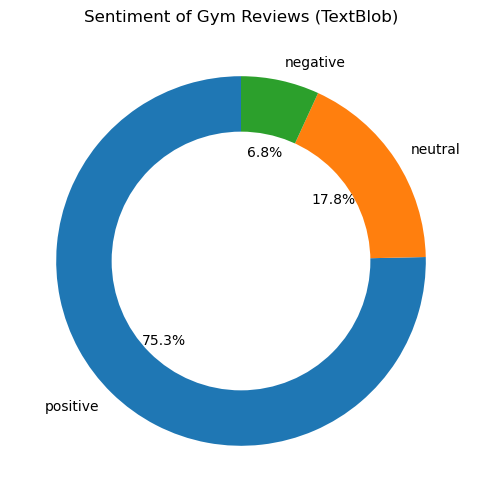

In [20]:
labels = sent_counts.index
sizes = sent_counts.values

fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title("Sentiment of Gym Reviews (TextBlob)")
plt.show()

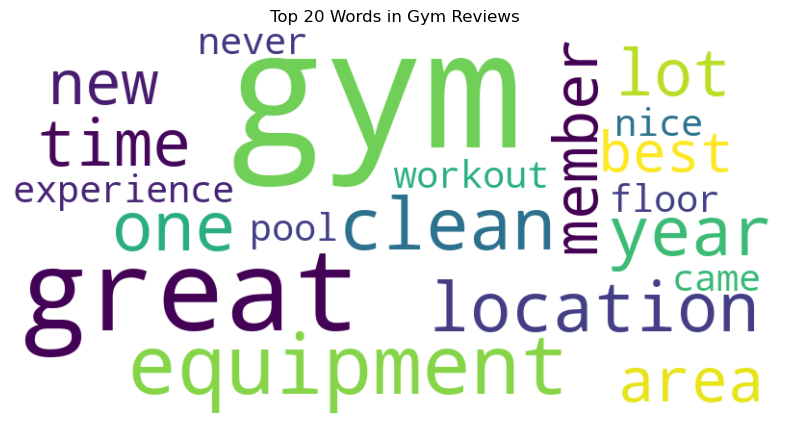

In [21]:
all_words = " ".join(reviews_df["clean_text"].tolist())

wc = WordCloud(width=800, height=400,
               background_color="white",
               max_words=20).generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Top 20 Words in Gym Reviews")
plt.show()

Overall most of the reviews were positive at over 75% positive. Second was neutral at just under 18% followed by negative reviews in last at under 7%. I learned that sentiment analysis can quickly and efficiently summarize a lot of data. I also learned the different sentiment models can occasionally disagree, so it's important to look over all of the data including text. 